In [1]:
import argparse
import torch
import sys
import os
import json
import random
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
import sklearn.covariance
import scipy
import pdb
import numpy as np
import random
import statistics
from matplotlib import pyplot as plt


import data_loader.data_loaders as module_data
import loss as module_loss
import model.metric as module_metric
import model.model as module_arch
import torch.nn as nn
import torch.nn.functional as F
import model.model as module_arch

from sklearn import metrics
from sklearn import cluster
from tqdm import tqdm
from torch.autograd import Variable
from parse_config import ConfigParser

In [2]:
read_path = './saved/mahalanobis/cifar10/resnet34/MultiStepLR/CCELoss/sym/0.8/'
# cifar10_feature_4_0.npy


In [3]:
config_file = './saved/models/cifar10/resnet34/MultiStepLR/CCELoss/sym/80/config_123.json'
with open(config_file, 'r') as f:
    config = json.load(f)
    
device = torch.device('cuda:0')

In [4]:
config['trainer']['percent'] = 0.8
config['trainer']['asym'] = False
config['train_loss']['type'] = 'CCELoss'
config

{'name': 'cifar10_resnet34_multistep',
 'n_gpu': 1,
 'seed': 123,
 'arch': {'type': 'resnet34', 'args': {'num_classes': 10}},
 'num_classes': 10,
 'data_loader': {'type': 'CIFAR10DataLoader',
  'args': {'data_dir': './dir_to_data',
   'batch_size': 128,
   'shuffle': True,
   'num_batches': 0,
   'validation_split': 0,
   'num_workers': 8,
   'pin_memory': True}},
 'optimizer': {'type': 'SGD',
  'args': {'lr': 0.02, 'momentum': 0.9, 'weight_decay': 0.001}},
 'train_loss': {'type': 'CCELoss'},
 'val_loss': 'CrossEntropyLoss',
 'metrics': ['my_metric', 'my_metric2'],
 'lr_scheduler': {'type': 'MultiStepLR',
  'args': {'milestones': [40, 80], 'gamma': 0.01}},
 'trainer': {'epochs': 120,
  'warmup': 0,
  'save_dir': 'saved/',
  'save_period': 1,
  'verbosity': 2,
  'label_dir': 'saved/',
  'monitor': 'max test_my_metric',
  'early_stop': 2000,
  'tensorboard': False,
  'mlflow': True,
  '_percent': 'Percentage of noise',
  'percent': 0.8,
  '_begin': 'When to begin updating labels',
  'beg

In [5]:
resume_path = './saved/models/cifar10/resnet34/MultiStepLR/GCELoss/sym/40/model_best123.pth'
base_model = getattr(module_arch, config["arch"]['type'])()
checkpoint = torch.load(resume_path)
state_dict = checkpoint['state_dict']
base_model.load_state_dict(state_dict)

<All keys matched successfully>

# Base Model and DataLoader

In [12]:
# set seed
random.seed(config['seed'])
torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])
torch.backends.cudnn.deterministic = True
np.random.seed(config['seed'])

data_loader = getattr(module_data, config['data_loader']['type'])(
    config['data_loader']['args']['data_dir'],
    batch_size= 100,
    shuffle=config['data_loader']['args']['shuffle'],
    validation_split=0.0,
    num_batches=config['data_loader']['args']['num_batches'],
    training=True,
    num_workers=config['data_loader']['args']['num_workers'],
    pin_memory=config['data_loader']['args']['pin_memory'],
    config=config
)

if hasattr(data_loader.dataset, 'num_raw_example'):
    num_examp = data_loader.dataset.num_raw_example
else:
    num_examp = len(data_loader.dataset)


# criterion = getattr(module_loss, 'GCELoss')(q=config['train_loss']['args']['q'],
#                                             k=config['train_loss']['args']['k'],
#                                             trainset_size=num_examp,
#                                             truncated=config['train_loss']['args']['truncated'])

Files already downloaded and verified
Train: 50000 Val: 0


In [13]:
class Represent(nn.Module):
    def __init__(self, base_model):
        super(Represent, self).__init__()
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4
        self.linear = base_model.linear
        
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        y = out.view(out.size(0), -1)
        
        return y
    
    #Feature Extractting
    def feature_list(self, x):
        output_list = []
        out = F.relu(self.bn1(self.conv1(x)))
        for name, module in self.layer1._modules.items():
            out = module(out)
        for name, module in self.layer2._modules.items():
            out = module(out)
        for name, module in self.layer3._modules.items():
            out = module(out)
        for name, module in self.layer4._modules.items():
            out = module(out)
            output_list.append(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y, output_list

In [14]:
model = Represent(base_model)

In [15]:
isNoisy_list = np.empty((0,))
isFalse_list = np.empty((0,))
label_list = np.empty((0,))
gt_list = np.empty((0,))
conf_list = np.empty((0,))
loss_list = np.empty((0,))

model.eval()
model.to(device)

with tqdm(data_loader) as progress:
    for batch_idx, (data, label, index, label_gt) in enumerate(progress):
        data = data.to(device)
        label, label_gt = label.long().to(device), label_gt.long().to(device)
        output = model(data)
        _,prediction = base_model(data)
        loss = torch.nn.CrossEntropyLoss(reduction='none')(prediction, label)
        confidence, _ = torch.max(torch.nn.functional.softmax(prediction, dim=1), dim=1)
        isNoisy = label != label_gt
        
        gt_list = np.concatenate((gt_list, label_gt.cpu()))
        label_list = np.concatenate((label_list, label.cpu()))
        isNoisy_list = np.concatenate((isNoisy_list, isNoisy.cpu()))
        conf_list = np.concatenate((conf_list, confidence.detach().cpu()))
        loss_list = np.concatenate((loss_list, loss.detach().cpu()))
        if batch_idx == 0:
            out_list = output.detach().cpu()
        else:
            out_list = np.concatenate((out_list, output.detach().cpu()), axis=0)

100%|██████████| 500/500 [00:29<00:00, 16.83it/s]


In [16]:
labbb = torch.from_numpy(label_list).long()

In [17]:
labbb

tensor([6, 6, 1,  ..., 0, 1, 6])

In [18]:
out_list.shape

(50000, 512)

In [19]:
def get_singular_value_vector(label_list, out_list):
    
    singular_dict = {}
    v_ortho_dict = {}
    
    for index in np.unique(label_list):
        u, s, v = np.linalg.svd(out_list[label_list==index])
        singular_dict[index] = s[0] / s[1]
        v_ortho_dict[index] = torch.from_numpy(v[:2])

    return singular_dict, v_ortho_dict

In [20]:
def singular_label(v_ortho_dict, model_represents, label):
    
    model_represents = torch.from_numpy(model_represents).to(device)
    sing_lbl = torch.zeros(model_represents.shape[0]) 
    sin_score_lbl = torch.zeros(model_represents.shape[0])
    
    for i, data in enumerate(model_represents):
        sin_score_lbl[i] = torch.dot(v_ortho_dict[label[i]][0], data).abs() - torch.dot(v_ortho_dict[label[i]][1], data).abs()
        if torch.dot(v_ortho_dict[label[i]][0], data).abs() < torch.dot(v_ortho_dict[label[i]][1], data).abs():
            sing_lbl[i] = 1
        
    return sing_lbl, sin_score_lbl

In [21]:
singular_dict, v_ortho_dict = get_singular_value_vector(label_list, out_list)

for key in v_ortho_dict.keys():
    v_ortho_dict[key] = v_ortho_dict[key].to(device)

sing_lbl, sin_score_lbl = singular_label(v_ortho_dict, out_list, label_list)

In [22]:
sing_lbl.shape

torch.Size([50000])

In [23]:
#Selected Output

singular_output  = torch.from_numpy(out_list[sing_lbl==0])
print(singular_output.shape)

torch.Size([23383, 512])


In [24]:
#Selected target correspoding to selected output
sel_label = labbb[sing_lbl==0]
print(sel_label.shape)

torch.Size([23383])


### Compute total mean and covariance for each class

In [25]:
def get_mean_covariance(feature, total_label, num_classes):
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered = False)   
    new_feature, fraction_list = [], []
    sample_mean_per_class = torch.Tensor(10, feature.size(1)).fill_(0).cuda()
    total_label = total_label.cuda()

    
    for i in range(num_classes):
        index_list = total_label.eq(i)
        tmp_x = feature[index_list.nonzero(), :]
        tmp_x = tmp_x.view(tmp_x.size(0), -1)
        sample_mean_per_class[i].copy_(torch.mean(tmp_x, 0))

        new_feature.append(tmp_x) 
        fraction_list.append(tmp_x.size(0))
        
    total_covariance = 0
    for i in range(10):
        flag = 0
        X = 0
        for j in range(fraction_list[i]):
            tmp_feature = new_feature[i][j]
            tmp_feature = tmp_feature - sample_mean_per_class[i]
            tmp_feature = tmp_feature.view(-1,1)
            if flag == 0:
                X = tmp_feature.transpose(0,1)
                flag = 1
            else:
                X = torch.cat((X, tmp_feature.transpose(0,1)),0)

        group_lasso.fit(X.cpu().numpy())
        inv_sample_conv = group_lasso.covariance_
        inv_sample_conv = torch.from_numpy(inv_sample_conv).float().cuda()
        if i == 0:
            total_covariance = inv_sample_conv*fraction_list[i]
        else:
            total_covariance += inv_sample_conv*fraction_list[i]

        total_covariance = total_covariance/sum(fraction_list)
    new_precision = scipy.linalg.pinvh(total_covariance.cpu().numpy())
    new_precision = torch.from_numpy(new_precision).float().cuda()
    
    return sample_mean_per_class, new_precision
    

In [27]:
sample_mean, sample_precision = get_mean_covariance(singular_output.cuda(), sel_label, 10)
print(sample_mean)
print(sample_precision)

<ipython-input-25-6b5128979664>:10: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  tmp_x = feature[index_list.nonzero(), :]


tensor([[0.1488, 0.4693, 0.0126,  ..., 0.0422, 0.2411, 0.0399],
        [0.1410, 0.1092, 0.0486,  ..., 0.4310, 0.0667, 0.4055],
        [0.1357, 0.1325, 0.0493,  ..., 0.0645, 0.1563, 0.0813],
        ...,
        [0.0124, 0.0815, 0.1552,  ..., 0.1266, 0.0193, 0.1286],
        [0.4024, 0.2024, 0.0208,  ..., 0.1251, 0.2460, 0.1069],
        [0.1155, 0.3591, 0.0196,  ..., 0.1225, 0.1191, 0.1172]],
       device='cuda:0')
tensor([[ 4.6212e+02,  1.1194e+02,  5.6258e+01,  ..., -5.0781e+01,
          2.8196e+01, -4.1597e+01],
        [ 1.1194e+02,  5.6627e+02, -5.8346e+01,  ..., -5.5217e-01,
          5.9187e+01, -3.4841e+00],
        [ 5.6258e+01, -5.8346e+01,  3.3814e+02,  ...,  3.3974e+01,
          6.6227e+01, -4.5310e+01],
        ...,
        [-5.0781e+01, -5.5217e-01,  3.3974e+01,  ...,  4.3561e+02,
         -2.8437e+01, -1.4687e+01],
        [ 2.8196e+01,  5.9187e+01,  6.6227e+01,  ..., -2.8437e+01,
          6.0587e+02, -1.3664e+02],
        [-4.1597e+01, -3.4841e+00, -4.5310e+01,  .

In [28]:
print(sample_precision.shape)
print(sample_precision)


torch.Size([512, 512])
tensor([[ 4.6212e+02,  1.1194e+02,  5.6258e+01,  ..., -5.0781e+01,
          2.8196e+01, -4.1597e+01],
        [ 1.1194e+02,  5.6627e+02, -5.8346e+01,  ..., -5.5217e-01,
          5.9187e+01, -3.4841e+00],
        [ 5.6258e+01, -5.8346e+01,  3.3814e+02,  ...,  3.3974e+01,
          6.6227e+01, -4.5310e+01],
        ...,
        [-5.0781e+01, -5.5217e-01,  3.3974e+01,  ...,  4.3561e+02,
         -2.8437e+01, -1.4687e+01],
        [ 2.8196e+01,  5.9187e+01,  6.6227e+01,  ..., -2.8437e+01,
          6.0587e+02, -1.3664e+02],
        [-4.1597e+01, -3.4841e+00, -4.5310e+01,  ..., -1.4687e+01,
         -1.3664e+02,  4.9091e+02]], device='cuda:0')


In [29]:
def mahalanobis_distance(feature, sample_mean, inverse_covariance):
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    temp_batch = 100
    total, mahalanobis_score = 0, 0
    
    for data_index in range(int(np.ceil(feature.size(0)/temp_batch))):
        temp_feature = feature[total : total + temp_batch].cuda()        
        gaussian_score = 0
        batch_sample_mean = sample_mean
        zero_f = temp_feature - batch_sample_mean
        term_gau = 0.5*torch.mm(torch.mm(zero_f, inverse_covariance), zero_f.t()).diag()
        # concat data
        if total == 0:
            mahalanobis_score = term_gau.view(-1,1)
        else:
            mahalanobis_score = torch.cat((mahalanobis_score, term_gau.view(-1,1)), 0)
        total += temp_batch
    
    mahalanobis_score = mahalanobis_score.view(-1)
        
    return mahalanobis_score
    

In [30]:
def mal_list(feature, total_target, sam_mean, sam_precision, num_classes):
    mahal_list = []
    for i in range(10):
        index_list = total_target.eq(i)
        tmp_x = feature[index_list.nonzero(), :]
        tmp_x = tmp_x.view(tmp_x.size(0), -1)
        mahal_list.append(mahalanobis_distance(tmp_x.cuda(), sam_mean[i], sam_precision))
        
    return mahal_list


In [31]:
aa = mal_list(singular_output.cuda(), sel_label, sample_mean, sample_precision, 10)

In [32]:
# aa list containing mahalanobis distance across class
aa[0].shape

torch.Size([2730])

In [36]:
for i in range(10):
    print('class',i,'max:', max(aa[i]))
    print('class',i,'min:', min(aa[i]))
    print('class',i,'median:', statistics.median(aa[i]))

class 0 max: tensor(11734.8428, device='cuda:0')
class 0 min: tensor(106.4293, device='cuda:0')
class 0 median: tensor(317.9929, device='cuda:0')
class 1 max: tensor(18957.8809, device='cuda:0')
class 1 min: tensor(26.8511, device='cuda:0')
class 1 median: tensor(134.4972, device='cuda:0')
class 2 max: tensor(18829.3984, device='cuda:0')
class 2 min: tensor(488.5957, device='cuda:0')
class 2 median: tensor(2377.7825, device='cuda:0')
class 3 max: tensor(24590.2773, device='cuda:0')
class 3 min: tensor(647.1175, device='cuda:0')
class 3 median: tensor(2177.1340, device='cuda:0')
class 4 max: tensor(18941.7949, device='cuda:0')
class 4 min: tensor(535.7272, device='cuda:0')
class 4 median: tensor(2916.7783, device='cuda:0')
class 5 max: tensor(15086.3076, device='cuda:0')
class 5 min: tensor(378.2017, device='cuda:0')
class 5 median: tensor(3880.2053, device='cuda:0')
class 6 max: tensor(15015.7568, device='cuda:0')
class 6 min: tensor(130.9791, device='cuda:0')
class 6 median: tensor(76

In [37]:
aaa = aa[0].cpu().detach().numpy()

(array([ 12.,  77., 175., 202., 198., 222., 181., 146., 139., 125.,  94.,
         81.,  67.,  60.,  57.,  62.,  37.,  31.,  34.,  27.,  32.,  12.,
         25.,  20.,  20.,  14.,  21.,  12.,  17.,   8.,  11.,   9.,  13.,
          5.,   6.,   3.,   7.,   5.,   7.,   2.,   6.,   6.,   7.,  10.,
          5.,   6.,   5.,   3.,   3.,   4.,   3.,   4.,   0.,   4.,   1.,
          1.,   3.,   2.,   1.,   2.,   2.,   6.,   0.,   1.,   2.,   1.,
          1.,   1.,   0.,   1.,   0.,   2.,   2.,   2.,   0.,   1.,   1.,
          0.,   0.,   2.,   2.,   2.,   1.,   2.,   2.,   1.,   1.,   0.,
          2.,   1.,   3.,   3.,   3.,   1.,   2.,   1.,   2.,   2.,   0.,
          0.,   2.,   2.,   0.,   2.,   1.,   2.,   1.,   2.,   1.,   1.,
          1.,   0.,   0.,   4.,   1.,   1.,   0.,   1.,   3.,   2.,   1.,
          0.,   1.,   3.,   1.,   2.,   2.,   0.,   2.,   1.,   1.,   0.,
          0.,   2.,   2.,   2.,   1.,   0.,   2.,   4.,   0.,   0.,   0.,
          0.,   2.,   0.,   1.,   0., 

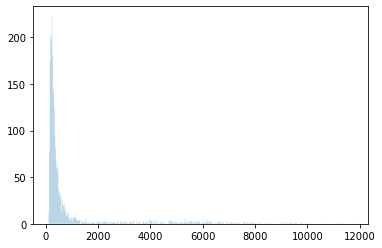

In [38]:
plt.hist(aaa, histtype='stepfilled', alpha=0.3, bins=500, density=False)

### Data for computing MCD

In [39]:
for batch_idx, (data, target, index, label_gt) in enumerate(data_loader):
    data, target, label_gt = data.cuda(), target.cuda(), label_gt.cuda()
    if batch_idx == 0:
        total_data = data
        total_target = target
        total_label_gt = label_gt
    else:
        total_data = torch.cat((total_data, data), 0)
        total_target = torch.cat((total_target, target), 0)
        total_label_gt = torch.cat((total_label_gt, label_gt), 0)

In [40]:
#Noise rate check
tmp = 0
for i in range(len(total_label_gt)):
    if total_target[i] != total_label_gt[i]:
        tmp += 1
print('Noise rate: ', tmp/len(total_label_gt))

Noise rate:  0.72072


In [41]:
model.eval()
model.to(device)

temp_x = torch.rand(2,3,32,32).cuda()
temp_x = Variable(temp_x, volatile=True)
temp_list = model.feature_list(temp_x)[1]
num_output = len(temp_list) # Number of layers that extracts feature
total_final_feature = [0]*num_output #Extracted Features
total = 0
batch_size = 100

for data_index in range(int(np.floor(total_data.size(0)/batch_size))):
    data = total_data[total : total + batch_size]
    data = Variable(data, volatile=True)

    _, out_features = model.feature_list(data)
    for i in range(num_output):
        out_features[i] = out_features[i].view(out_features[i].size(0), out_features[i].size(1), -1)
        out_features[i] = torch.mean(out_features[i].data, 2)
        if total == 0:
            total_final_feature[i] = out_features[i].cpu().clone()
        else:
            total_final_feature[i] = torch.cat((total_final_feature[i], out_features[i].cpu().clone()), 0)
    total += batch_size

<ipython-input-41-6d51e0369ed1>:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  temp_x = Variable(temp_x, volatile=True)
<ipython-input-41-6d51e0369ed1>:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data = Variable(data, volatile=True)


### Only for using saved feature .npy

In [ ]:
total_feature_list = []
for i in range(3):
    tmp_feature = torch.from_numpy(np.load(read_path+'cifar10_feature_4_'+str(i)+'.npy')).cpu()
    total_feature_list.append(tmp_feature)
    print(type(tmp_feature))

total_target = torch.from_numpy(np.load('./saved/mahalanobis/cifar10/resnet34/MultiStepLR/GCELoss/sym/0.4/cifar10_target_noise.npy')).long()
total_label_gt = torch.from_numpy(np.load('./saved/mahalanobis/cifar10/resnet34/MultiStepLR/GCELoss/sym/0.4/cifar10_label_gt.npy')).long()

### Mahalanobis for MCD

In [43]:
# features of 3 layers [50000, 512]
total_final_feature

# target including noisy labels
total_target

# ground truth label
total_label_gt

#
num_output = len(total_final_feature)

In [44]:
#Random Sample Mean
def random_sample_mean(feature, total_label, num_classes):
    
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered = False)    
    new_feature, fraction_list = [], []
    frac = 0.7
    sample_mean_per_class = torch.Tensor(num_classes, feature.size(1)).fill_(0).cuda()
    total_label = total_label.cuda()

    
    total_selected_list = []
    for i in range(num_classes):
        index_list = total_label.eq(i)
        temp_feature = feature[index_list.nonzero(), :]
        temp_feature = temp_feature.view(temp_feature.size(0), -1)

        shuffler_idx = torch.randperm(temp_feature.size(0))
        index = shuffler_idx[:int(temp_feature.size(0)*frac)]
        fraction_list.append(int(temp_feature.size(0)*frac))
        total_selected_list.append(index_list.nonzero()[index.cuda()])


        selected_feature = torch.index_select(temp_feature, 0, index.cuda())
        new_feature.append(selected_feature)
        sample_mean_per_class[i].copy_(torch.mean(selected_feature, 0))

    total_covariance = 0
    for i in range(num_classes):
        flag = 0
        X = 0
        for j in range(fraction_list[i]):
            temp_feature = new_feature[i][j]

            temp_feature = temp_feature - sample_mean_per_class[i]
            temp_feature = temp_feature.view(-1,1)
            if flag  == 0:
                X = temp_feature.transpose(0,1)
                flag = 1
            else:
                X = torch.cat((X,temp_feature.transpose(0,1)),0)
            # find inverse            
        group_lasso.fit(X.cpu().numpy())
        inv_sample_conv = group_lasso.covariance_
        inv_sample_conv = torch.from_numpy(inv_sample_conv).float().cuda()
        if i == 0:
            total_covariance = inv_sample_conv*fraction_list[i]
        else:
            total_covariance += inv_sample_conv*fraction_list[i]
        total_covariance = total_covariance/sum(fraction_list)
    new_precision = scipy.linalg.pinvh(total_covariance.cpu().numpy())
    new_precision = torch.from_numpy(new_precision).float().cuda()

    
    return sample_mean_per_class, new_precision, total_selected_list

In [45]:
print('Random Sample Mean')
sample_mean_list, sample_precision_list = [], []
total_label_list = [total_target for i in range(3)]

for index in range(3):
    sample_mean, sample_precision, _ = random_sample_mean(total_final_feature[index].cuda(), total_label_list[index].cuda(), config['num_classes'])
    sample_mean_list.append(sample_mean)
    sample_precision_list.append(sample_precision)

Random Sample Mean


In [46]:
len(sample_mean_list)
len(sample_precision_list)

3

In [47]:
sample_precision_list[2]

tensor([[ 920.1540,  -43.0862,   97.5807,  ..., -179.5037,  -16.3750,
           21.4863],
        [ -43.0862, 1197.1914,  -26.9887,  ...,  114.3012,   12.1584,
          -52.1778],
        [  97.5807,  -26.9887,  506.6533,  ..., -175.3536,   47.5371,
           99.1817],
        ...,
        [-179.5037,  114.3013, -175.3537,  ..., 1130.5620,   23.0996,
         -278.0416],
        [ -16.3750,   12.1584,   47.5370,  ...,   23.0996,  771.8832,
         -190.1959],
        [  21.4863,  -52.1778,   99.1817,  ..., -278.0416, -190.1959,
          927.7223]], device='cuda:0')

In [48]:
import pdb

#MCD single
def MCD_single(feature, sample_mean, inverse_covariance):
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    temp_batch = 100
    total, mahalanobis_score = 0, 0
    frac = 0.7 #fraction N_c+d+1 / 2
    for data_index in range(int(np.ceil(feature.size(0)/temp_batch))):
        temp_feature = feature[total : total + temp_batch].cuda()        
        gaussian_score = 0
        batch_sample_mean = sample_mean
        zero_f = temp_feature - batch_sample_mean
        term_gau = -0.5*torch.mm(torch.mm(zero_f, inverse_covariance), zero_f.t()).diag()
        # concat data
        if total == 0:
            mahalanobis_score = term_gau.view(-1,1)
        else:
            mahalanobis_score = torch.cat((mahalanobis_score, term_gau.view(-1,1)), 0)
        total += temp_batch
        
    mahalanobis_score = mahalanobis_score.view(-1)
    feature = feature.view(feature.size(0), -1)
    selected_mahal, selected_idx = torch.topk(mahalanobis_score, int(feature.size(0)*frac))
    print('Total mahal shape:', mahalanobis_score.shape, 'Selected mahal shape: ', selected_mahal.shape)
    selected_feature = torch.index_select(feature, 0, selected_idx.cuda())
    new_sample_mean = torch.mean(selected_feature, 0)
    
    # compute covariance matrix
    X = 0
    flag = 0
    for j in range(selected_feature.size(0)):
        temp_feature = selected_feature[j]
        temp_feature = temp_feature - new_sample_mean
        temp_feature = temp_feature.view(-1,1)
        if flag  == 0:
            X = temp_feature.transpose(0,1)
            flag = 1
        else:
            X = torch.cat((X, temp_feature.transpose(0,1)),0)
    # find inverse            
    group_lasso.fit(X.cpu().numpy())
    new_sample_cov = group_lasso.covariance_
    
    return new_sample_mean, new_sample_cov, selected_idx, selected_mahal

In [49]:
print('Single MCD and merge the parameters')
new_sample_mean_list = []
new_sample_precision_list = []
selected_feature = []
layer_selected_index = []
total_mahla_layer = []

for index in range(num_output):
    tmp_selected_idx = []
    tmp_mahal_class = []

    new_sample_mean = torch.Tensor(config['num_classes'], total_final_feature[index].size(1)).fill_(0).cuda()
    
    new_covariance = 0
    for i in range(config['num_classes']):
        index_list = total_label_list[index].eq(i)
        temp_feature = total_final_feature[index][index_list.nonzero(), :]
        tmp_idx_list = index_list.nonzero().view(-1).detach().cpu()
#         print(temp_feature.shape)
        temp_feature = temp_feature.view(temp_feature.size(0), -1)
        temp_mean, temp_cov, tmp_idx, tmp_mahal = MCD_single(temp_feature.cuda(), sample_mean_list[index][i], sample_precision_list[index])
#         print('selcted index for class', i, ':', tmp_idx.shape)
        new_sample_mean[i].copy_(temp_mean)
        tmp_real_idx = tmp_idx_list[tmp_idx.detach().cpu()]
        tmp_selected_idx.extend(tmp_real_idx.tolist())
        tmp_mahal_class.append(tmp_mahal)


        if i  == 0:
            new_covariance = temp_feature.size(0)*temp_cov
        else:
            new_covariance += temp_feature.size(0)*temp_cov
        
    layer_selected_index.append(tmp_selected_idx)
    total_mahla_layer.append(tmp_mahal_class)
            
    new_covariance = new_covariance / total_final_feature[index].size(0)
    new_precision = scipy.linalg.pinvh(new_covariance)
    new_precision = torch.from_numpy(new_precision).float().cuda()
    new_sample_mean_list.append(new_sample_mean)
    new_sample_precision_list.append(new_precision)

G_soft_list = []
target_mean = new_sample_mean_list 
target_precision = new_sample_precision_list


Single MCD and merge the parameters
Total mahal shape: torch.Size([4976]) Selected mahal shape:  torch.Size([3483])
Total mahal shape: torch.Size([5087]) Selected mahal shape:  torch.Size([3560])
Total mahal shape: torch.Size([4918]) Selected mahal shape:  torch.Size([3442])
Total mahal shape: torch.Size([5030]) Selected mahal shape:  torch.Size([3521])
Total mahal shape: torch.Size([5028]) Selected mahal shape:  torch.Size([3519])
Total mahal shape: torch.Size([5027]) Selected mahal shape:  torch.Size([3518])
Total mahal shape: torch.Size([5033]) Selected mahal shape:  torch.Size([3523])
Total mahal shape: torch.Size([5005]) Selected mahal shape:  torch.Size([3503])
Total mahal shape: torch.Size([4933]) Selected mahal shape:  torch.Size([3453])
Total mahal shape: torch.Size([4963]) Selected mahal shape:  torch.Size([3474])
Total mahal shape: torch.Size([4976]) Selected mahal shape:  torch.Size([3483])
Total mahal shape: torch.Size([5087]) Selected mahal shape:  torch.Size([3560])
Tota

In [50]:
#Mahalanobis distance list for layer 2
layer2_mahal = total_mahla_layer[2]

### Comparing mahalanobis distance eigen vs MCD in classwise manner

In [110]:
mcd_mahal0 = -layer2_mahal[3].cpu().detach().numpy()
eigen_mahal0 = aa[3].cpu().detach().numpy()

In [111]:
mcd_mahal0.shape

(3521,)

In [112]:
eigen_mahal0.shape

(2043,)

In [113]:
max(mcd_mahal0)

511.7668

In [114]:
max(eigen_mahal0)

24590.277

In [115]:
min(mcd_mahal0)

61.069557

In [116]:
min(eigen_mahal0)

647.1175

In [117]:
statistics.median(mcd_mahal0)

313.20895

In [118]:
statistics.median(eigen_mahal0)

2177.134

(array([  0.,   0.,   2.,  16.,  79., 176., 268., 293., 215., 151., 120.,
         85.,  55.,  61.,  34.,  35.,  24.,  26.,  30.,  18.,  11.,  14.,
         14.,  18.,   6.,   9.,  21.,   8.,   9.,  16.,  13.,   7.,   5.,
         18.,  14.,   5.,   7.,   7.,   9.,   3.,  15.,  11.,   9.,   9.,
          2.,   5.,  12.,   6.,   4.,   4.,   5.,   8.,   1.,   2.,   2.,
          8.,   3.,   2.,   3.,   6.,   1.,   2.,   2.,   2.,   2.,   3.,
          0.,   0.,   3.,   3.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([    0.     ,   245.90277,   491.80554,   737.7083 ,   983.6111 ,
         1229.5139 ,  1475.4166 ,  1721.3195 ,  1967.2222 ,  2213.125  ,
         2459.0278 ,  2704.9304 ,  2950.8333 ,  3196.736  ,  3442.639  ,
         3688.5415 ,  3934.4443 ,  4180.347  ,  4426.25   ,  4672.153  ,
         4918.0557 ,  5163

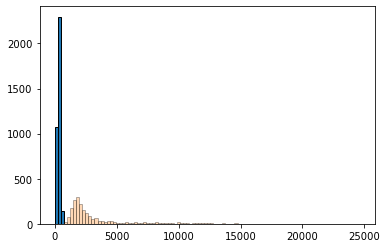

In [119]:
plt.hist(mcd_mahal0, histtype='bar', range=(0, max(eigen_mahal0)), alpha=1, bins=100, ec='k', density=False)
plt.hist(eigen_mahal0, histtype='bar', range=(0, max(eigen_mahal0)), alpha=0.3, bins=100, ec='k',density=False)